In [1]:
import imageio
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib
matplotlib.style.use('ggplot')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
batch_size = 512
epochs = 10
sample_size = 64
nz = 128
k = 1

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

train_dataset = datasets.MNIST(
    root="./content/data.zip", train=True, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

100%|██████████| 9.91M/9.91M [00:00<00:00, 14.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 473kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.84MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.11MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [7]:
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

losses_g = []
losses_d = []
images = []

In [8]:
def save_generator_image(image, path):
    save_image(image, path)

In [9]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    fake_label = torch.zeros(b_size, 1).to(device)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [10]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [11]:
!mkdir img #img 폴더 만들기

In [12]:
generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for idx, data in tqdm(enumerate(train_loader), total=int(len(train_dataset)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        for step in range(k):
            data_fake = generator(torch.randn(b_size, nz).to(device)).detach()
            data_real = image
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(torch.randn(b_size, nz).to(device))
        loss_g += train_generator(optim_g, data_fake)
    generated_img = generator(torch.randn(b_size, nz).to(device)).cpu().detach()
    generated_img = make_grid(generated_img)
    save_generator_image(generated_img, "./img/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / idx
    epoch_loss_d = loss_d / idx
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

118it [00:22,  5.21it/s]                         


Epoch 0 of 10
Generator loss: 1.38228893, Discriminator loss: 0.88919359


118it [00:17,  6.84it/s]                         

Epoch 1 of 10
Generator loss: 3.19579029, Discriminator loss: 1.16498268



118it [00:12,  9.62it/s]                         

Epoch 2 of 10
Generator loss: 6.64113998, Discriminator loss: 0.22797990



118it [00:12,  9.73it/s]                         


Epoch 3 of 10
Generator loss: 6.08410215, Discriminator loss: 0.24643047


118it [00:12,  9.57it/s]                         

Epoch 4 of 10
Generator loss: 6.89591551, Discriminator loss: 0.57910138



118it [00:13,  8.83it/s]                         

Epoch 5 of 10
Generator loss: 5.54253769, Discriminator loss: 0.66897637



118it [00:12,  9.58it/s]                         

Epoch 6 of 10
Generator loss: 5.87952662, Discriminator loss: 0.52815598



118it [00:12,  9.37it/s]                         

Epoch 7 of 10
Generator loss: 4.73284245, Discriminator loss: 0.53850472



118it [00:12,  9.08it/s]                         

Epoch 8 of 10
Generator loss: 2.74401903, Discriminator loss: 0.81362683



118it [00:12,  9.31it/s]                         

Epoch 9 of 10
Generator loss: 3.25921917, Discriminator loss: 0.78046650


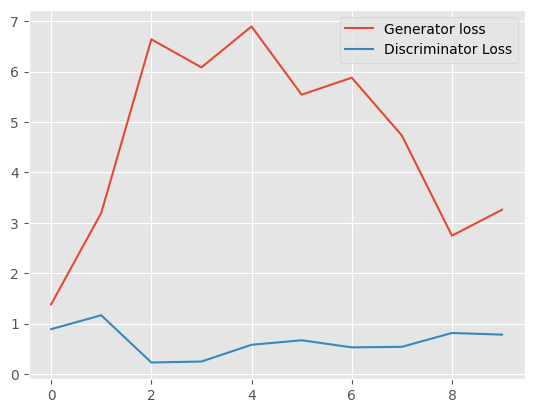

In [13]:
plt.figure()
losses_g = [fl.item() for fl in losses_g ]
plt.plot(losses_g, label='Generator loss')
losses_d = [f2.item() for f2 in losses_d ]
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()

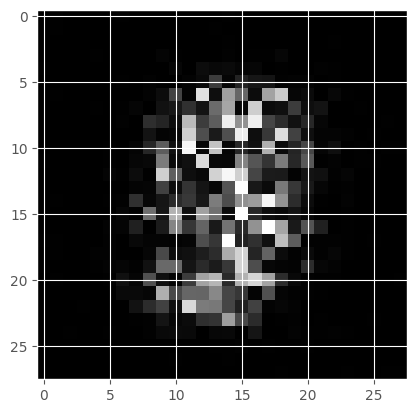

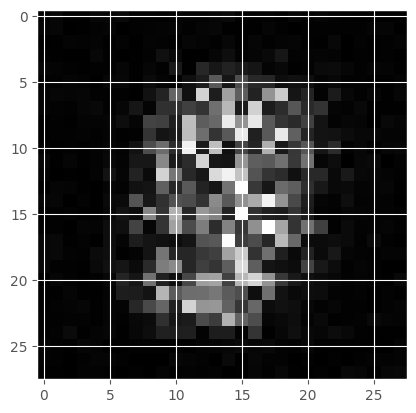

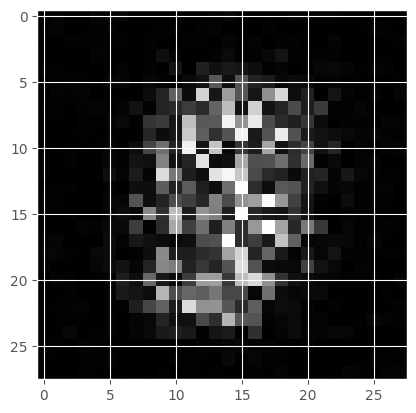

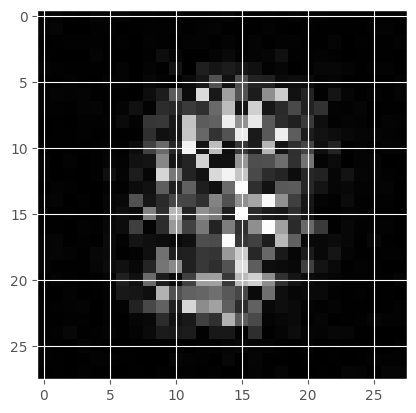

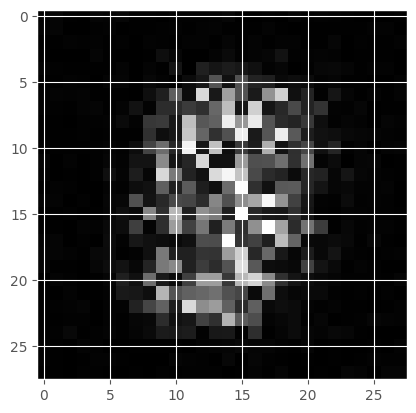

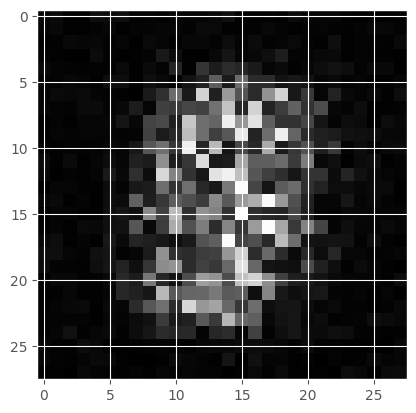

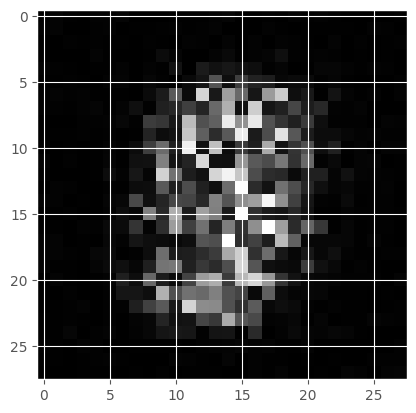

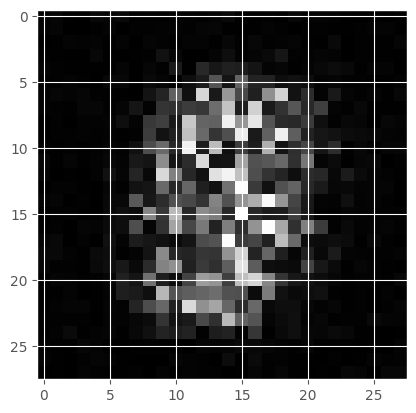

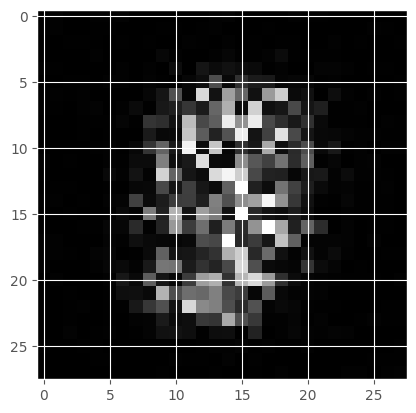

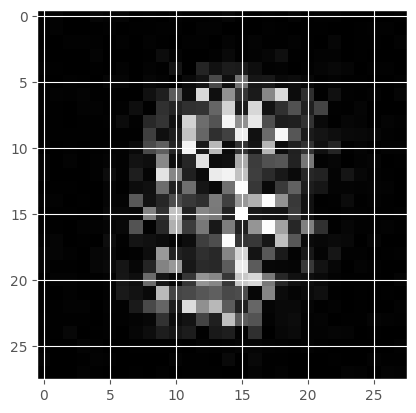

In [15]:
import numpy as np
fake_images = generator(torch.randn(b_size, nz).to(device))
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')
    plt.show()